 # Skin Diasese detection test

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.__version__

'2.10.0'

## Preprocessing

In [5]:

# Common parameters
BATCH_SIZE   = 32
IMG_SIZE     = (224, 224)
DATA_DIR     = r"C:\Users\User\Downloads\Skin-disease-dataset\train"
SEED         = 42           # keeps split reproducible
VAL_SPLIT    = 0.20         # 80 % train, 20 % validation

datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=VAL_SPLIT      # ← **key line**
)



training_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',              # ← **80 % of images**
    shuffle=True,
    seed=SEED
)

test_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',            # ← **20 % of images**
    shuffle=True,
    seed=SEED
)


Found 32907 images belonging to 5 classes.
Found 8224 images belonging to 5 classes.


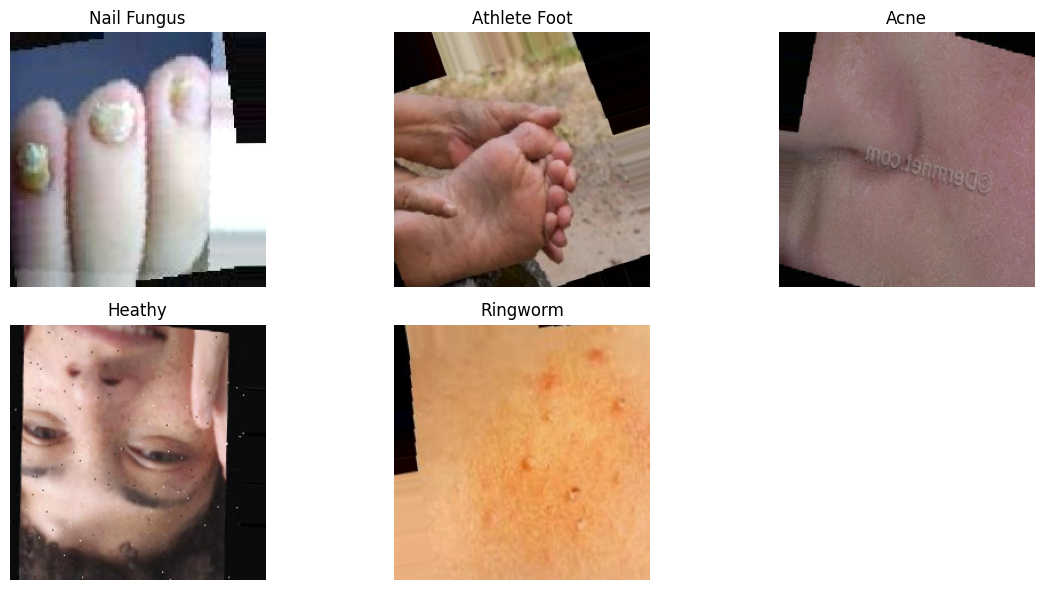

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load class indices (label → index mapping)
class_indices = training_set.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Create a map to store one image per class
seen_classes = set()
images = []
labels = []

# Iterate over batches to collect one image per class
for i in range(len(training_set)):
    x_batch, y_batch = training_set[i]
    for img, label in zip(x_batch, y_batch):
        class_index = np.argmax(label)
        if class_index not in seen_classes:
            seen_classes.add(class_index)
            images.append(img)
            labels.append(index_to_class[class_index])
        if len(seen_classes) == len(index_to_class):
            break
    if len(seen_classes) == len(index_to_class):
        break

# Plot the collected images
plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(2, (len(images) + 1) // 2, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


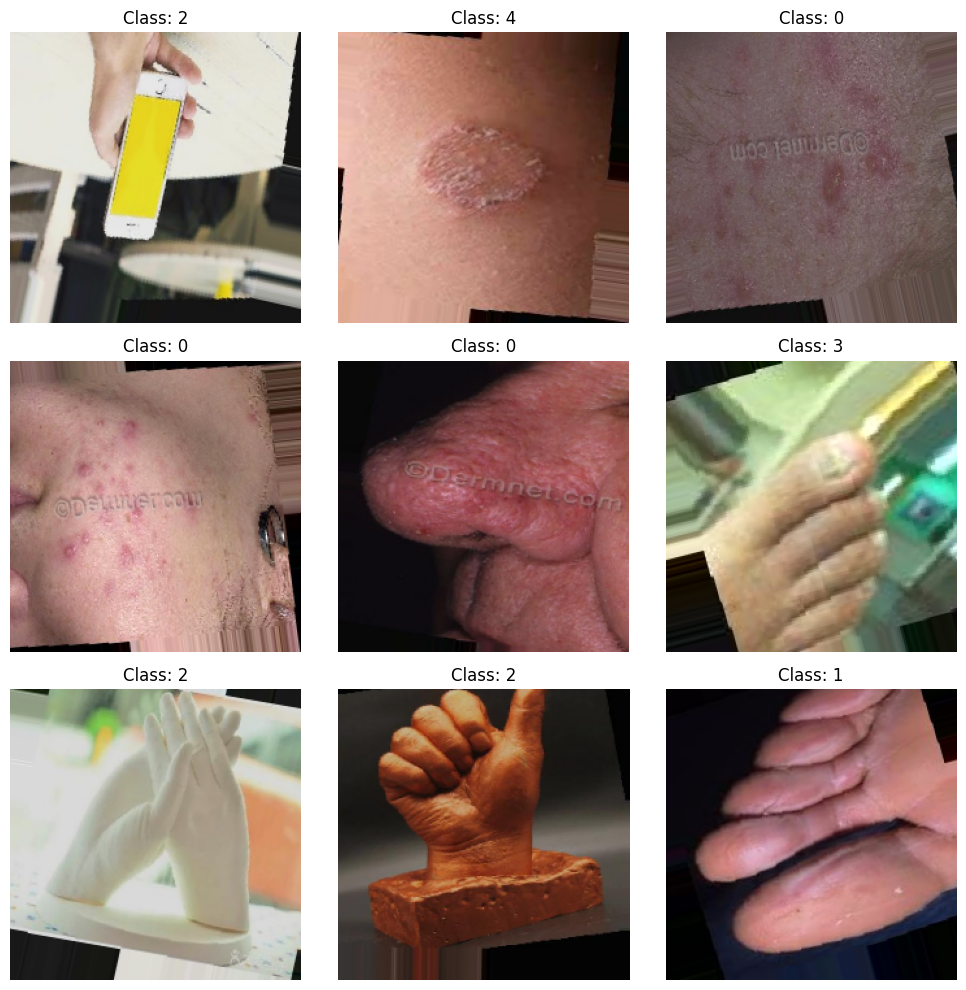

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the training set
images, labels = next(training_set)

# Show 9 augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


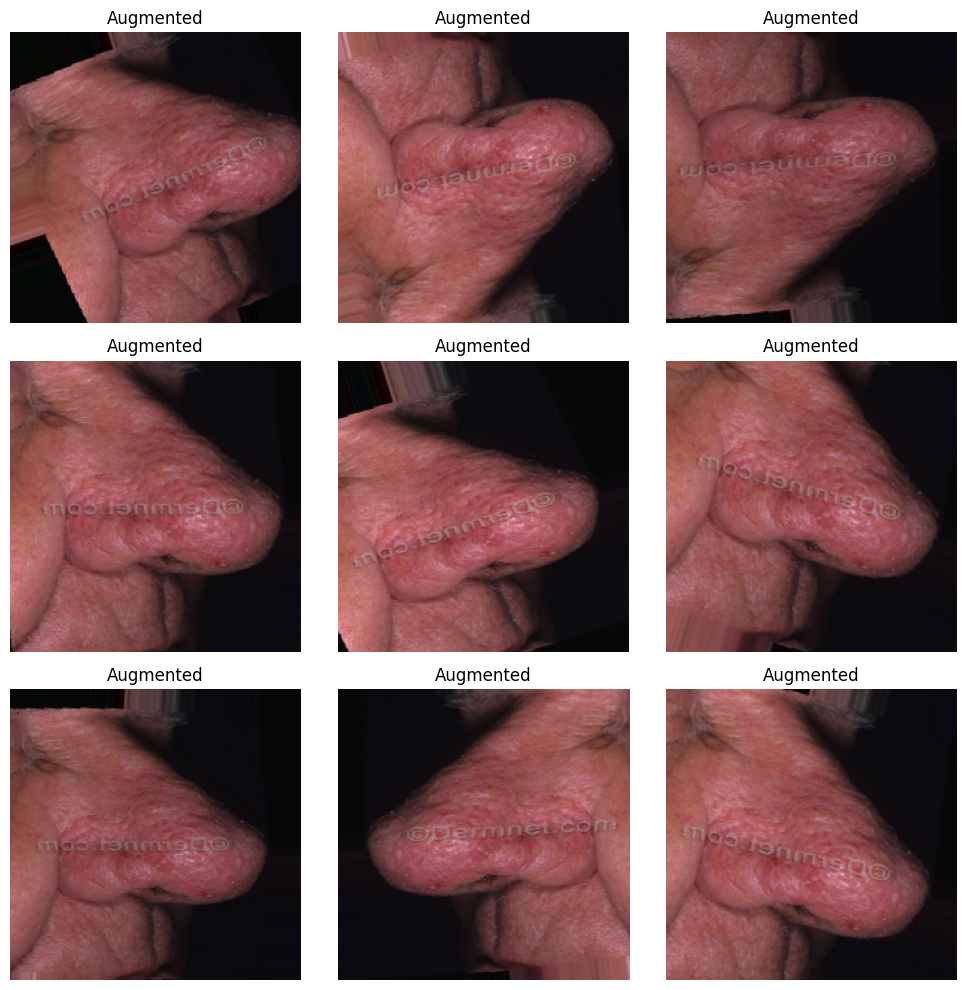

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a single image path
img_path = training_set.filepaths[0]
img = image.load_img(img_path, target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Show multiple augmented versions
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented = datagen.flow(x, batch_size=1)
    aug_img = next(augmented)[0]  # single image in batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Building the CNN

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


# Load Pretrained MobileNetV2 (Exclude top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-40]: 
    layer.trainable = False



# Add Custom Classification Head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])




# Train Model
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Stage 1
base_model.trainable = False
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(training_set, validation_data=test_set, epochs=10, callbacks=callbacks)
 
# Stage 2
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(training_set, validation_data=test_set, epochs=20, callbacks=callbacks)



Epoch 1/10
1029/1029 [==============================] - 422s 401ms/step - loss: 0.1429 - accuracy: 0.9557 - val_loss: 0.0480 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 2/10
1029/1029 [==============================] - 403s 391ms/step - loss: 0.0662 - accuracy: 0.9805 - val_loss: 0.0358 - val_accuracy: 0.9891 - lr: 0.0010
Epoch 3/10
1029/1029 [==============================] - 375s 365ms/step - loss: 0.0580 - accuracy: 0.9831 - val_loss: 0.0320 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 4/10
1029/1029 [==============================] - 357s 346ms/step - loss: 0.0458 - accuracy: 0.9869 - val_loss: 0.0313 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 5/10
1029/1029 [==============================] - 379s 368ms/step - loss: 0.0433 - accuracy: 0.9874 - val_loss: 0.0385 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 6/10
1029/1029 [==============================] - 376s 366ms/step - loss: 0.0470 - accuracy: 0.9881 - val_loss: 0.0537 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 7/10
1029/1029 [============

In [10]:
model.save("four_skin_disease_detection")

INFO:tensorflow:Assets written to: four_skin_disease_detection\assets


INFO:tensorflow:Assets written to: four_skin_disease_detection\assets


In [11]:
# Save the full model (includes weights, architecture, optimizer config)
model.save("four_skin_disease_detection.h5")  # Save as HDF5 file

In [ ]:
with open("retrainable_model.tflite", "wb") as f:
    f.write(tflite_model)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,     # Use TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS        # Also allow full TF ops (e.g., GradientTape)
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

with open("retrainable_model.tflite", "wb") as f:
    f.write(tflite_model)


In [13]:
# Training progress
# Combine history from both stages
import pandas as pd

combined_history = {}
for key in history1.history:
    combined_history[key] = history1.history[key] + history2.history[key]



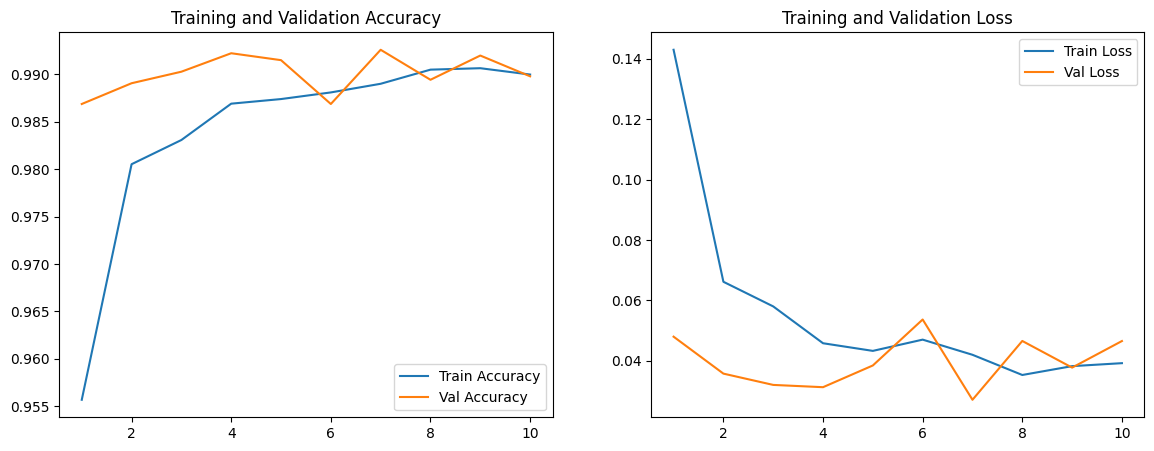

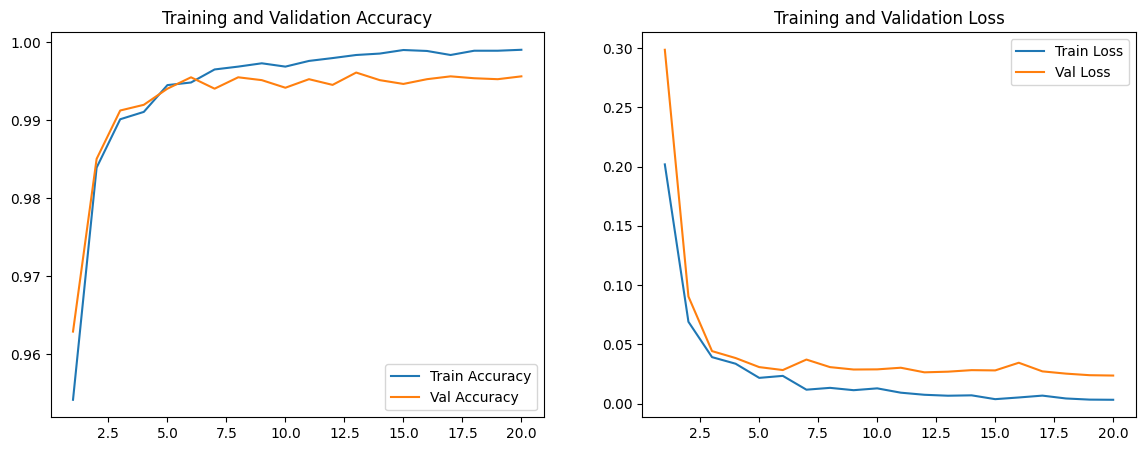

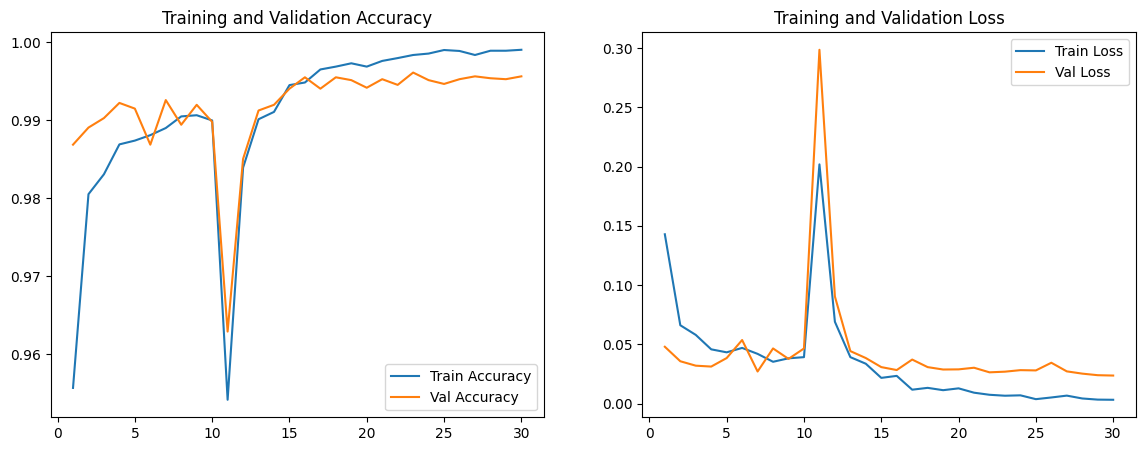

In [14]:
# Training progress
import matplotlib.pyplot as plt

def plot_history(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Use for single stage:
plot_history(history1.history)
plot_history(history2.history)

# Or for combined:
plot_history(combined_history)


1/1 [==============================] - 0s 26ms/step


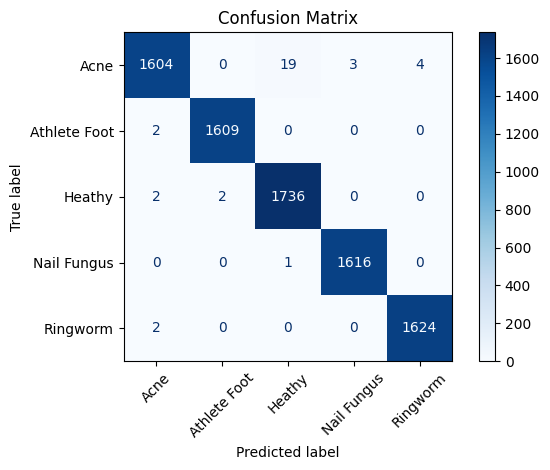

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get true labels and predictions
Y_true = []
Y_pred = []

# Go through test batches and collect predictions
for i in range(len(test_set)):
    x_batch, y_batch = test_set[i]
    y_pred_batch = model.predict(x_batch)
    
    Y_true.extend(np.argmax(y_batch, axis=1))
    Y_pred.extend(np.argmax(y_pred_batch, axis=1))

    if (i + 1) * test_set.batch_size >= test_set.samples:
        break  # Stop if we've processed all test data

# 2. Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
labels = list(test_set.class_indices.keys())  # Class names

# 3. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
print(training_set.class_indices)